# Gradient Bandit Algorithm


In Gradient Bandit Algorithm instead of always picking the action with the highest Q value, we can say that the probability of choosing an action is proportional to its Q value. This means actions with higher Q values are more likely to be chosen, but lower-Q actions still have a chance, which helps with exploration. In practice, we usually normalize these values so they form valid probabilities (often using a softmax function with a constant that controls how strongly the policy prefers higher Q values). When the constant is large, the policy behaves almost greedily; when it is small, the policy becomes more exploratory. This approach balances trying good actions while still occasionally testing others.



Watch video form 30:45-48:48


In [76]:
from IPython.display import IFrame

IFrame('https://www.youtube.com/embed/aQJP3Z2Ho8U?start=1800', width=800, height=450)


## Installation

In [77]:
! pip install numpy==1.26.4 matplotlib==3.8.4 torch==2.5.1

  Using cached numpy-1.26.4-cp313-cp313-macosx_26_0_arm64.whl
  Using cached matplotlib-3.8.4.tar.gz (35.9 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for matplotlib (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [1064 lines of output]
      
      Edit mplsetup.cfg to change the build options; suppress output with --quiet.
      
      BUILDING MATPLOTLIB
            python: yes [3.13.5 | packaged by Anaconda, Inc. | (main, Jun 12 2025,
                        11:23:37) [Clang 14.0.6 ]]
          platform: yes [darwin]
             tests: no  [skipping due to configuration]
            macosx: yes [installing]
      
      /private/var/folders/23/hlzjw9hx3bv2hyzkvrv3rj280000gn/T/pip-build-env-a4e4xxc6/overlay/lib/python3.13/site-packages/setuptools_scm/git.py:427: UserWarning: git archive did not support describe 

## Gradient Bandit Algorithms

###  The Softmax Policy in Bandit Algorithms
In the Gradient Bandit, the probability of choosing action $a$ (or policy) is given by the softmax function.

$$\pi_{\theta}(a) = \frac{e^{H_{\theta}(a)}}{\sum_{b=1}^{K} e^{H_{\theta}(b)}}$$

**$H_{\theta}(a)$** is the learned numerical **preference** (or logit). This exponentiated values are positive; as such, their sum with respect to action $a$ is 1. The parameters $\theta$ are obtained through training. We select the action with the largest probability.

$$A_t = \arg\max_a\{ \pi_{\theta}(a)\} $$

For example K=3: $\pi_{\theta}(1)=0.25$, $\pi_{\theta}(2)=0.50$ and $\pi_{\theta}(3)=0.25$

$A_1 = \arg\max_a \{0.25, 0.5,0.25 \}$  
$A_1 =2$

### Action Preference ($H_{\theta}(a)$) in the Model

In the `SimpleLinearModel`, the action preference $H_{\theta}(a)$ is the direct, linear output of the network *before* the Softmax is applied. This preference is calculated using the learned weights ($\mathbf{w}$), the bias ($b$), and the fixed input vector ($\mathbf{x}$):

$$H_{\theta}(a) = \mathbf{w}_a^T \mathbf{x}$$

Since the model fixes the input $\mathbf{x}$ for $a=j$ the single feature $x_j=1$, this simplifies the preference to:

$H_{\theta}(a) = w_a$

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from deepmind_bandits import GaussianBandits, BanditDataAnalyzer

# Set random seed
np.random.seed(42)
torch.manual_seed(42)

## PyTorch Model Implementation

In PyTorch, we can easily implement the softmax function. The input dimension is typically 1, and the output dimension corresponds to the number of classes. Unlike the standard softmax function, where all inputs are treated as features with equal weighting, we implement it within the forward function.

In [ ]:
class SimpleLinearModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleLinearModel, self).__init__()
        # Linear layer: learns action preferences H(a) = w_a for each action
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self):
        x = torch.tensor([1.0])  # Fixed input (bandit has no state)
        # Returns raw logits (action preferences) before softmax
        return self.linear(x)

## Policy Gradient Derivation

We have a policy parameterized by $\theta$ that defines a probability distribution $\pi_\theta(a)$ over actions. Each action $a$ has a true mean reward $q(a)$. Our goal is to choose $\theta$ so that the policy selects actions that maximize the expected reward. The expected reward under the policy is

$$
J(\theta) = \mathbb{E}[R \mid \pi_\theta] = \sum_a \pi_\theta(a)\, q(a).
$$

Since we are optimizing with respect to $\theta$, and the reward function $q(a)$ does not depend on $\theta$, the gradient of the objective is

$$
\nabla_\theta J(\theta)
= \nabla_\theta \sum_a \pi_\theta(a)\, q(a)
= \sum_a q(a)\, \nabla_\theta \pi_\theta(a).
$$

Using the log-derivative trick:

$$
\nabla_\theta \pi_\theta(a)
= \pi_\theta(a)\, \nabla_\theta \log \pi_\theta(a).
$$

Substituting this gives

$$
\nabla_\theta J(\theta)
= \sum_a q(a)\, \pi_\theta(a)\, \nabla_\theta \log \pi_\theta(a).
$$

Since actions are drawn according to $A \sim \pi_\theta(a)$, the sum above is an expectation:

$$
\nabla_\theta J(\theta)
\approx
\frac{1}{N}\sum_{t=1}^N q(A_t)\,\nabla_\theta \log \pi_\theta(A_t),
\qquad A_t \sim \pi_\theta.
$$

## REINFORCE Update Rule

In the bandit setting, we do not know the true action-value function $q(a)$. Instead, after selecting an action $A_t$, we observe a reward sample $R_t$, which is an unbiased estimator of $q(A_t)$.

Since $q(a)$ is unknown, we replace it with the sampled reward $R_t$, yielding the Monte Carlo policy gradient estimator:

$$
\nabla_\theta J(\theta)
\approx R_t\, \nabla_\theta \log \pi_\theta(A_t).
$$

Using this estimator, we update the policy parameters via gradient ascent:

$$
\theta_{t+1}
= \theta_t + \alpha_t\, R_t\, \nabla_\theta \log \pi_\theta(A_t).
$$

This gives the **REINFORCE** update rule in the bandit setting:

$$
\theta \leftarrow \theta + \alpha\, R\, \nabla_\theta \log \pi_\theta(A).
$$

## Loss Function

The loss function in PyTorch (cross-entropy with logits) is given by:

$$
\ell_t
= - \sum_{a=1}^{C} \mathbf{1}[A_t = a]\,
\ln\left( \frac{e^{w_a}}{\sum_{i=1}^{C} e^{w_i}} \right).
$$

This simplifies to:

$$
\ell_t = - \ln\!\bigl(\pi_\theta(A_t)\bigr).
$$

To recover the bandit policy-gradient form, we multiply by the reward $R_t$:

$$
\ell_t = -\, R_t\, \ln\!\bigl(\pi_\theta(A_t)\bigr).
$$

Subtract the mean reward as a baseline to make learning more stable.  
Instead of using the raw reward $R_t$, we use $R_t - \bar{R}$.  
Actions that perform better than average are reinforced, while actions that perform worse than average are discouraged.  
This subtraction does not change the expected gradient, only reduces its variance, leadin

In [ ]:
def bandit_loss(logits, actions, rewards):
    """Policy gradient loss for bandits: -R * log π(A)"""
    rewards = torch.tensor(rewards, requires_grad=False)
    # Cross-entropy gives -log π(A), multiply by reward for policy gradient
    return rewards * F.cross_entropy(logits, actions)

## Setup Environment and Model

In [81]:
# Environment setup
means = [1.0, 2.0, -1.0, 0.0]
stds = [0.1, 0.2, 0.1, 0.3]
env = GaussianBandits(means, stds)
num_arms = env.num_arms
num_actions = num_arms

print(f"Number of arms: {num_arms}")
print(f"True means: {means}")
print(f"Optimal arm: {np.argmax(means)} (mean={max(means)})")

Number of arms: 4
True means: [1.0, 2.0, -1.0, 0.0]
Optimal arm: 1 (mean=2.0)


In [ ]:
# Model configuration
lr = 0.1  # Learning rate for gradient ascent
T = 1000  # Number of training steps

# Initialize model with num_actions output neurons (one per action preference)
model = SimpleLinearModel(1, num_actions)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# Create analyzer to track performance
analyzer = BanditDataAnalyzer(means, num_actions)

# Baseline: running mean of rewards (reduces gradient variance)
running_mean = 0.0
n = 1

print(f"Learning rate: {lr}")
print(f"Total steps: {T}")

## Helper Function

In [83]:
def argmax_(z):
    """Get argmax and detach from computation graph."""
    return torch.argmax(z.detach())

## Training Loop

In [ ]:
for t in range(T):
    # Forward pass: compute action preferences H(a) for all actions
    logits = model()
    
    # Select action with highest preference (greedy w.r.t. current policy)
    action = torch.tensor(argmax_(logits))
  
    # Execute action in environment and observe reward
    reward = env.pull_arm(action)
    
    # Update baseline (running mean of rewards) for variance reduction
    running_mean = running_mean + (reward - running_mean) / n
    reward_zero_mean = reward - running_mean  # Center reward around baseline
    n += 1
    
    # Compute policy gradient loss: -R_t * log π(A_t)
    loss = bandit_loss(logits, action, reward_zero_mean)
    
    # Gradient ascent: update preferences to increase probability of good actions
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Track performance metrics
    analyzer.update_and_analyze(action.item(), reward, loss_sample=loss)

print(f"\nTraining completed: {T} steps")

## Analyze Results

In [85]:
analyzer.finalize_analysis()

### Q-Value Progression


This plot shows how the agent's Q-value estimates evolved during learning:
- **Solid colored lines**: Q-values for each action over time
- **Dashed lines**: True mean rewards (ground truth)
- **Red arrows**: When the agent switches between actions

**What to look for:**
- Q-values should converge toward the true means (dashed lines)
- More frequently selected actions have smoother estimates
- Early exploration causes more switching (red arrows)


We observe that once the algorithm selects an action, it converges if there is sufficient randomness. However, if it does not explore initially, it may never converge to the optimal action.


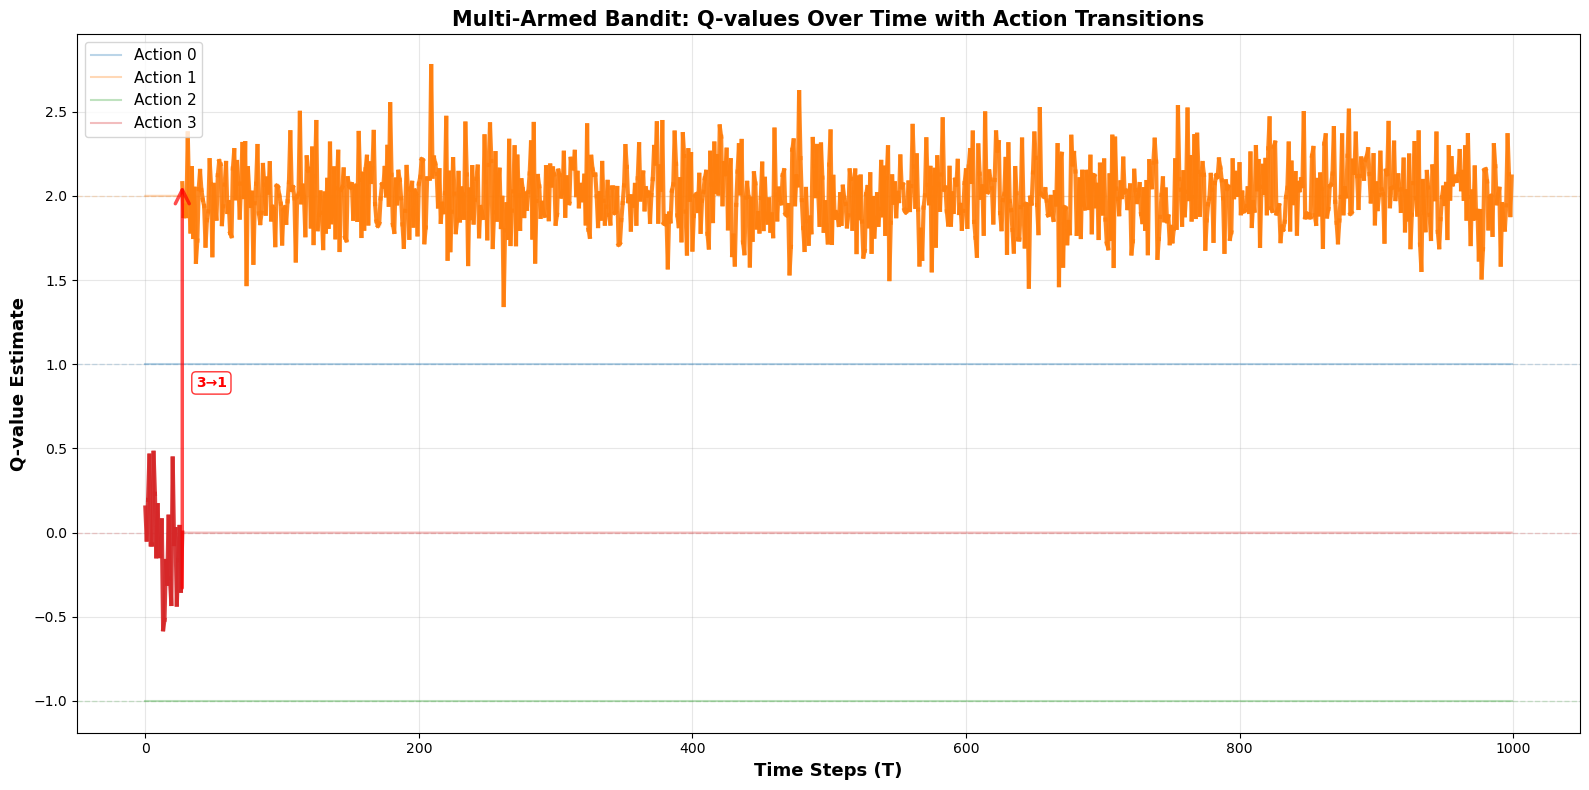


Transitions detected: 1
  Step 27: Action 3 → Action 1


In [86]:
analyzer.plot_Qvalue()

### Cumulative Regret and Loss

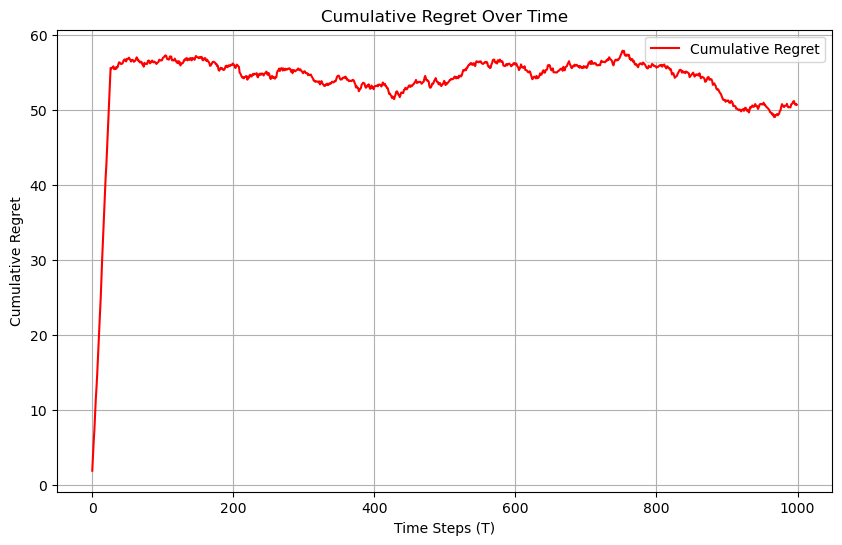

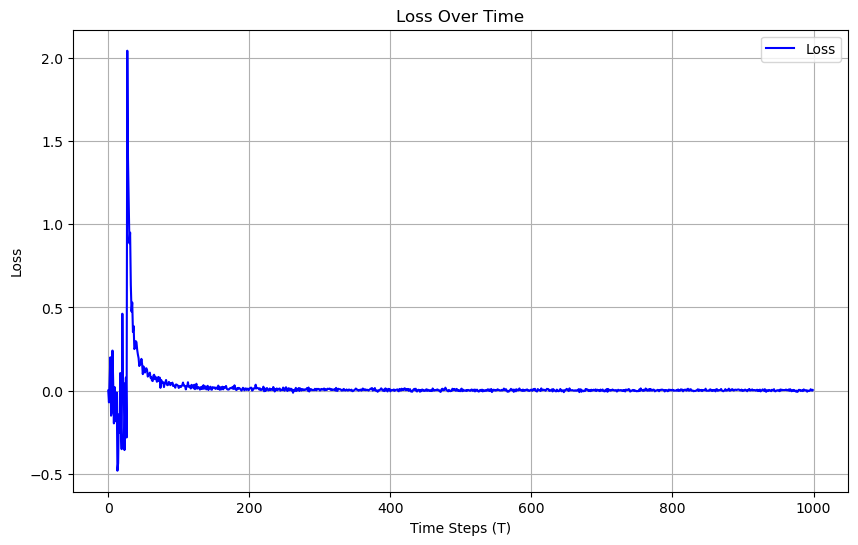

In [73]:
analyzer.plot_regret()

### Cumulative Reward

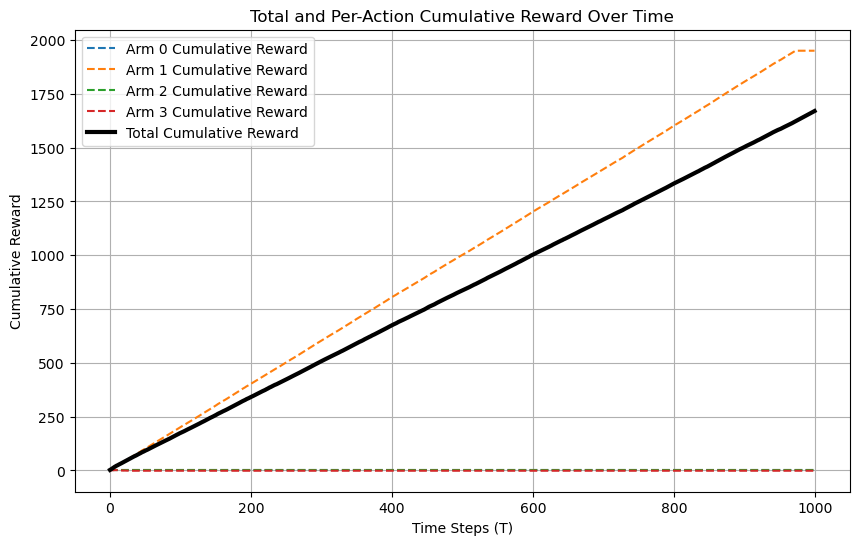

In [74]:
analyzer.plot_cumulative_reward()

## Model Weights (Learned Preferences)

In [75]:
print("=== Gradient Bandit Performance Summary ===")
print(f"\nLearned action preferences (weights):")
with torch.no_grad():
    final_logits = model()
    probs = F.softmax(final_logits, dim=0)
    for a in range(num_actions):
        print(f"  Arm {a}: H(a)={final_logits[a].item():.3f}, π(a)={probs[a].item():.3f} (true mean={means[a]:.3f})")

optimal_arm = np.argmax(means)
print(f"\nOptimal arm: {optimal_arm}")
print(f"Final cumulative regret: {analyzer.regret[-1]:.2f}")

=== Gradient Bandit Performance Summary ===

Learned action preferences (weights):
  Arm 0: H(a)=-0.525, π(a)=0.007 (true mean=1.000)
  Arm 1: H(a)=4.427, π(a)=0.981 (true mean=2.000)
  Arm 2: H(a)=-1.150, π(a)=0.004 (true mean=-1.000)
  Arm 3: H(a)=-0.390, π(a)=0.008 (true mean=0.000)

Optimal arm: 1
Final cumulative regret: 50.65


## Loss Distribution Histogram

Let's visualize the distribution of loss values during training. This helps us understand:
- How loss values are distributed
- Whether learning stabilized over time
- The range of loss values encountered

In [ ]:
# Extract loss values (convert from tensors to numpy)
loss_values = [loss.item() if torch.is_tensor(loss) else loss for loss in analyzer.loss]

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(loss_values, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Loss Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Loss Values During Training', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Add statistics
mean_loss = np.mean(loss_values)
median_loss = np.median(loss_values)
plt.axvline(mean_loss, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_loss:.3f}')
plt.axvline(median_loss, color='green', linestyle='--', linewidth=2, label=f'Median: {median_loss:.3f}')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Loss Statistics:")
print(f"  Mean: {mean_loss:.4f}")
print(f"  Median: {median_loss:.4f}")
print(f"  Std Dev: {np.std(loss_values):.4f}")
print(f"  Min: {np.min(loss_values):.4f}")
print(f"  Max: {np.max(loss_values):.4f}")

---

## Using GradientBanditAlgorithm Class

Now let's use the pre-built `GradientBanditAlgorithm` class from the `deepmind_bandits` package, which encapsulates all the functionality above.

In [ ]:
from deepmind_bandits import GradientBanditAlgorithm

# Reset environment and seed for fair comparison
np.random.seed(42)
torch.manual_seed(42)
env_class = GaussianBandits(means, stds)

# Create agent with GradientBanditAlgorithm class
agent = GradientBanditAlgorithm(num_actions=num_actions, lr=0.1, use_running_mean=True)

# Create new analyzer
analyzer_class = BanditDataAnalyzer(means, num_actions)

print(f"Created GradientBanditAlgorithm:")
print(f"  Number of actions: {agent.num_actions}")
print(f"  Using running mean baseline: {agent.use_running_mean}")
print(f"  Initial Q-values: {agent.Q}")

### Training with Class-Based Implementation

In [ ]:
T_class = 1000

for t in range(T_class):
    # Select action using the agent's policy
    action = agent.select_action()
    
    # Pull arm and observe reward
    reward = env_class.pull_arm(action)
    
    # Update agent (performs gradient ascent internally)
    agent.update_values(action, reward)
    
    # Track performance
    analyzer_class.update_and_analyze(action.item(), reward, loss_sample=agent.output_loss)

print(f"\nTraining completed: {T_class} steps")

### Results with GradientBanditAlgorithm Class

In [ ]:
analyzer_class.finalize_analysis()

print("=== GradientBanditAlgorithm Class Performance ===")
print(f"\nLearned Q-values:")
for a in range(num_actions):
    print(f"  Arm {a}: Q={agent.Q[a]:.3f} (true mean={means[a]:.3f})")

# Show learned preferences from the model
print(f"\nLearned action preferences (from model):")
with torch.no_grad():
    final_logits = agent.model()
    probs = F.softmax(final_logits, dim=0)
    for a in range(num_actions):
        print(f"  Arm {a}: H(a)={final_logits[a].item():.3f}, π(a)={probs[a].item():.3f}")

optimal_arm = np.argmax(means)
print(f"\nOptimal arm: {optimal_arm}")
print(f"Final cumulative regret: {analyzer_class.regret[-1]:.2f}")

In [ ]:
# Plot Q-value progression
analyzer_class.plot_Qvalue()

In [ ]:
# Plot cumulative regret
analyzer_class.plot_regret()

In [ ]:
# Plot cumulative reward
analyzer_class.plot_cumulative_reward()